# Enemy Noise

In [8]:
import pelita as pl
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

First we define some helper funtions. They are described in detail in `nb1_matplotlib_and_numpy.ipynb`.

In [9]:
def draw_coords(coords, ax, params={}):
    """
    Takes a list of coordinates and draws them as scatter elements onto a pyplot ax object

    Input:
    - coords: list of tuples of x,y coordinates
    - ax: a pyplot ax object
    - params: parameters to be passed to the scatter function (e.g. shape, size, color, etc.)
    Returns:
    - ax: a pyplot ax object
    """
    if type(coords)!=list:
        coords_x, coords_y = coords
    else:
        # get seperate lists of x and y coordinates from a list of tuples
        coords_x, coords_y = zip(*coords)
    ax.scatter(coords_x, coords_y, **params)
    return ax

In [10]:
def draw_game_elements(bot, ax):
    """
    Draws game state as scatter elements given a bot object.

    Input:
    - bot : pelita bot object
    - ax : a pyplot axis object
    Returns:
    -ax : a pyplot axis object
    """
    # Depending which team we are, we need to color the board appropriately
    if bot.is_blue:
        col_home_food = "blue"
        col_home_b1 = "green"
        col_home_b2 = "darkgreen"
        col_enemy_food = "red"
        col_enemy_b1 = "orange"
        col_enemy_b2 = "darkred"
    else:
        col_home_food = "red"
        col_home_b1 = "orange"
        col_home_b2 = "darkred"
        col_enemy_food = "blue"
        col_enemy_b1 = "green"
        col_enemy_b2 = "darkgreen"

    # Then we call the draw_coords function for each type of element we want to draw.
    # Each can be customized with whichever color, shape and size you want.
    ax = draw_coords(bot.position, ax, {"c": col_home_b1, "marker": "*", "s": 400})
    ax = draw_coords(bot.walls, ax, {"c": "black", "marker": "s", "s": 250})
    ax = draw_coords(bot.other.position, ax, {"c": col_home_b2, "marker": "*", "s": 400})
    ax = draw_coords(bot.food, ax, {"c": col_home_food, "s": 100})
    ax = draw_coords(bot.enemy[0].food, ax, {"c": col_enemy_food, "s": 100})
    ax = draw_coords(bot.enemy[0].position, ax, {"c": col_enemy_b1, "marker": "*", "s": 400})
    ax = draw_coords(bot.enemy[1].position, ax, {"c": col_enemy_b2, "marker": "*", "s": 400})
    ax.axvline(np.sum(ax.get_xlim()) / 2, c="black")
    # This is to get the coordinate system to have it's origin in the top left
    yd, yu = ax.get_ylim()
    if yd < yu:
        ax.invert_yaxis()
    return ax

## Enemy Noise
When they are more than 5 fields away, the position given by `bot.enemy.position` is noisy. This means that the true position of the enemy could be up to 5 fields away in any direction. For example

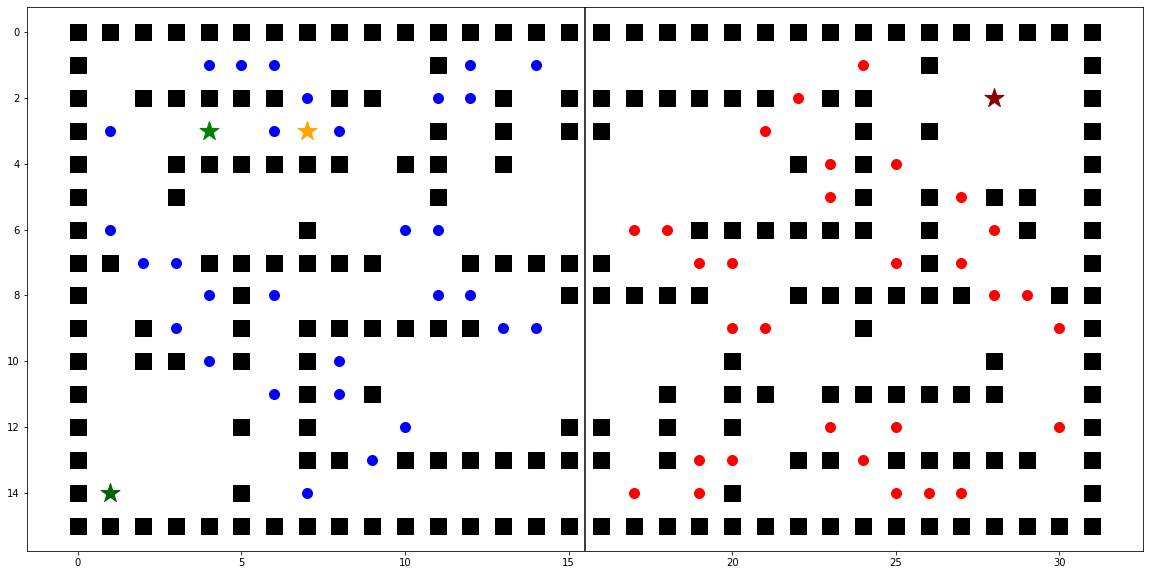

In [11]:
layout_str="""
################################
#   ...    #. .         . #    #
# #####.## ..# #######.##   ?  #
#.  0 .E.  # # ##    .  # #    #
#  ###### ## #        #.#.     #
#  #       #           .# #.## #
#.     #  ..     ..###### # .# #
##..######  #####  ..    .#.   #
#   .#.    ..  #####  ######..##
# #. # ######..     ..  #     .#
# ##.# #.           #       #  #
#     .#.#        # ## ######  #
#    # #  .    ## # #  . .    .#
#      ##.####### #.. ##.##### #
#1   # .         . .#    ...   #
################################
"""
bot = pl.utils.setup_test_game(layout=layout_str, is_blue=True)
fig, ax = plt.subplots(figsize=(20,10))
ax = draw_game_elements(bot, ax)

In this case 

In [12]:
print("enemy 0 is noisy: ", bot.enemy[0].is_noisy)
print("enemy 1 is noisy: ", bot.enemy[1].is_noisy)

enemy 0 is noisy:  False
enemy 1 is noisy:  True


Let's find all the fields the enemy could be on

In [13]:
maze_width = max([x for x, y in bot.walls])+1
maze_height = max([y for x, y in bot.walls])+1

In [14]:
possible_ys = np.linspace(-5,5,11, dtype=int) + bot.enemy[1].position[1]
possible_xs = np.linspace(-5,5,11, dtype=int) + bot.enemy[1].position[0]
yy, xx = np.meshgrid(possible_ys, possible_xs)
possible_xs2, possible_ys2 = np.vstack([xx.ravel(), yy.ravel()])

Then sort out fields that are outside the maze boundaries

In [15]:
mask = (possible_xs2 < maze_width) & (possible_xs2 >= 0) & (possible_ys2 >= 0) & (possible_ys2 < maze_height)
possible_xs2 = possible_xs2[mask]
possible_ys2 = possible_ys2[mask]

Now we can assign values to the fields in the maze, which correspond to the probability of having an enemy on it

In [16]:
# add a small eps value to the zeros, so we can display log-values. Otherwise we can't see small activations
enemy_prob = np.zeros((maze_height, maze_width))+np.finfo(float).eps
enemy_prob[possible_ys2,possible_xs2] = 1/(len(possible_ys)*len(possible_xs))
enemy_prob[bot.enemy[0].position[1], bot.enemy[0].position[0]] = 1

Plot the Probabilities using pyplot:

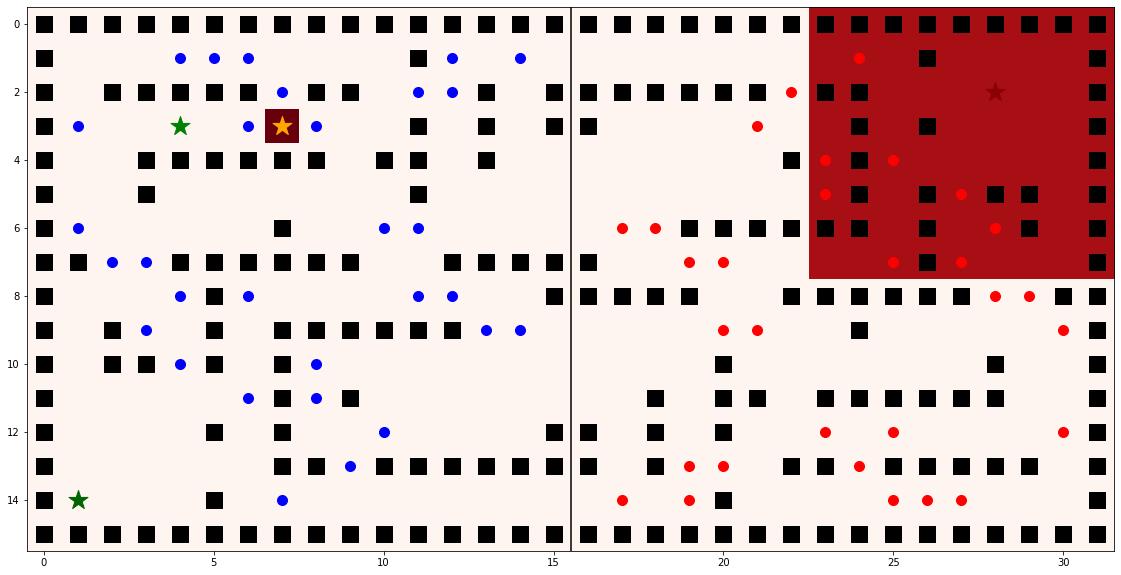

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(enemy_prob, norm=matplotlib.colors.LogNorm(), cmap="Reds")
ax = draw_game_elements(bot, ax)

When the enemy is closer (e.g. 6 fields away), the noise makes it possible for it to report being right next to you, like it would be possible in this example, using the same procedure as above:

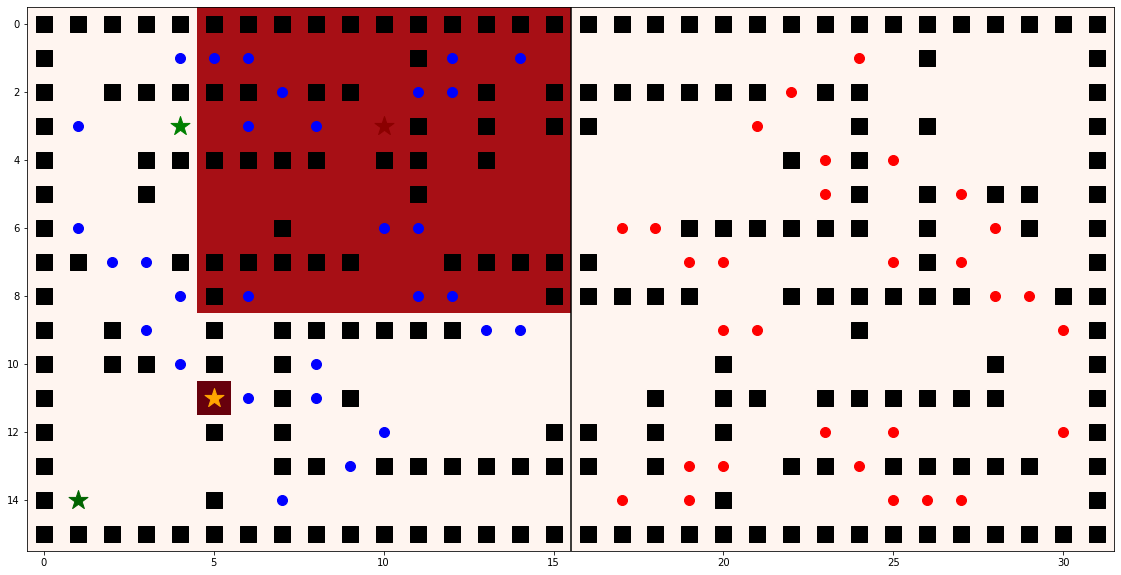

In [18]:
layout_str="""
################################
#   ...    #. .         . #    #
# #####.## ..# #######.##      #
#.  0 . . ?# # ##    .  # #    #
#  ###### ## #        #.#.     #
#  #       #           .# #.## #
#.     #  ..     ..###### # .# #
##..######  #####  ..    .#.   #
#   .#.    ..  #####  ######..##
# #. # ######..     ..  #     .#
# ##.# #.           #       #  #
#    E.#.#        # ## ######  #
#    # #  .    ## # #  . .    .#
#      ##.####### #.. ##.##### #
#1   # .         . .#    ...   #
################################
"""
bot = pl.utils.setup_test_game(layout=layout_str, is_blue=True)
maze_width = max([x for x, y in bot.walls])+1
maze_height = max([y for x, y in bot.walls])+1
possible_ys = np.linspace(-5,5,11, dtype=int) + bot.enemy[1].position[1]
possible_xs = np.linspace(-5,5,11, dtype=int) + bot.enemy[1].position[0]
yy, xx = np.meshgrid(possible_ys, possible_xs)
possible_xs2, possible_ys2 = np.vstack([xx.ravel(), yy.ravel()])
mask = (possible_xs2 < maze_width) & (possible_xs2 >= 0) & (possible_ys2 >= 0) & (possible_ys2 < maze_height)
possible_xs2 = possible_xs2[mask]
possible_ys2 = possible_ys2[mask]
enemy_prob = np.zeros((maze_height, maze_width))+np.finfo(float).eps
enemy_prob[possible_ys2,possible_xs2] = 1/(len(possible_ys)*len(possible_xs))
enemy_prob[bot.enemy[0].position[1], bot.enemy[0].position[0]] = 1

fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(enemy_prob, norm=matplotlib.colors.LogNorm(), cmap="Reds")
ax = draw_game_elements(bot, ax)